## 範例重點
* 了解如何在 Keras 中，加入 regularization (以 L2 regularization 為範例)
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 - Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶 L1/L2 的模型並訓練
"""
for reg_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    print(f"Experiment with Regularizer = {reg_ratio:.0e}")
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=reg_ratio)
    
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_data=(x_test, y_test), 
                        shuffle=True, 
                        verbose=0)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = (f"Regularizer ratio: {reg_ratio:.0e}")
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regularizer = 1e-02
Experiment with Regularizer = 1e-04
Experiment with Regularizer = 1e-08
Experiment with Regularizer = 1e-12


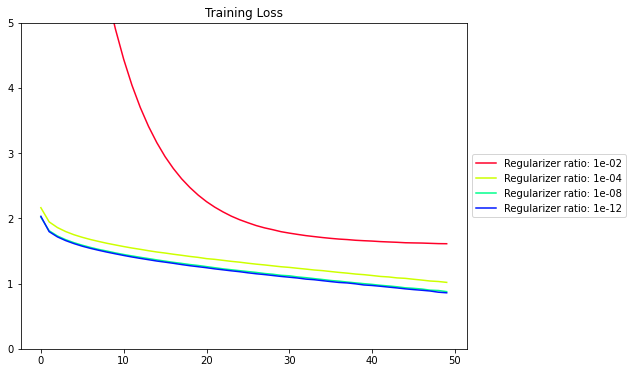

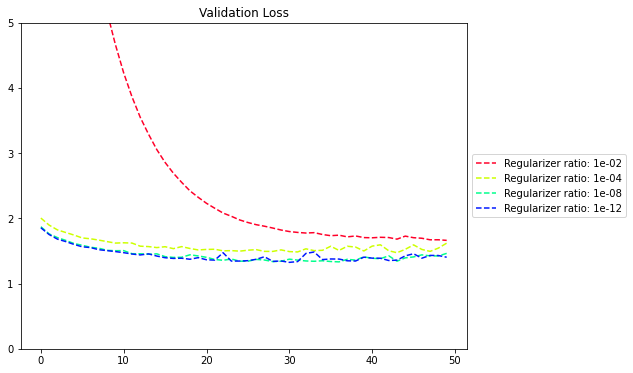

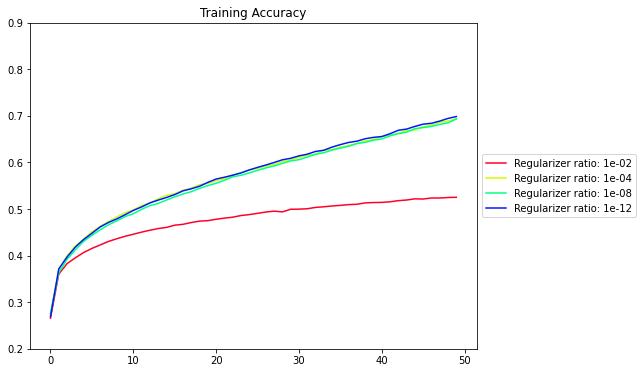

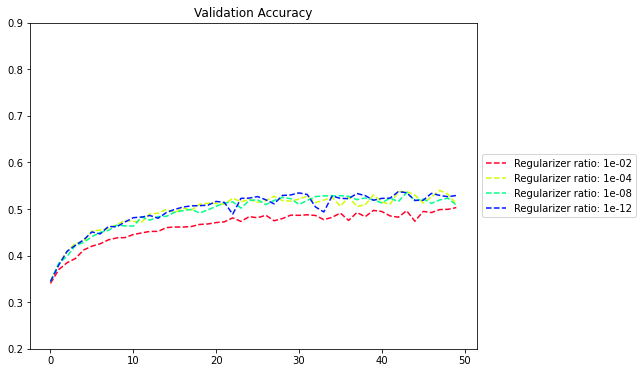

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Accuracy")
plt.ylim([0.2, 0.9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Accuracy")
plt.ylim([0.2, 0.9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果